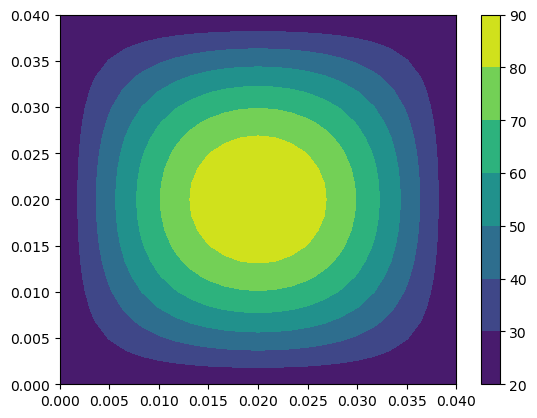

/Users/mostafakaviri/miniconda3/envs/mech579/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/Users/mostafakaviri/miniconda3/envs/mech579/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:728: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


In [ ]:
# Imports
import numpy as np # numpy for vectorization
from collections.abc import Callable # For type hints
import matplotlib.pyplot as plt
from scipy import optimize
class HeatEquation2D:
    """Heat Equation Solver for MECH 579 Final Project

    This class will construct and solve the unsteady heat equation
    with Robin BCs as described in the assignment.
    """
    def __init__(self, x:float, y:float, height:float , n_x:int, n_y:int,
                     k:float=1.0, rho:float=1.0, cp:float=1.0,
                     CFL:float=0.1, init_condition:Callable[[np.ndarray,np.ndarray], np.ndarray] = lambda x,y: np.sin(x+y)):
        """Intializition function for the heat equation

        Parameters

        ------

        x (float): Physical Size of CPU in x-direction [m]

        y (float): Physical Size of CPU in y-direction [m]

        n_x (int): Number of grid points in x-direction [m]

        n_y (int): Number of grid points in y-direction [m]

        k (float): The heat transfer coefficient of the CPU [W/[mK]]

        rho (float): Constant density of CPU [kg/m^3]

        cp (float): Specific heat capacity of CPU [kJ/[kgK]]

        CFL (float): Courant-Friedrichs-Lewy Number

        init_condition (function(x,y)): Initial condition of the CPU
        """
        ## MESHING variables
        self.n_x = n_x
        self.n_y = n_y
        self.boundary_conditions = []
        # Physical locations
        x_axis = np.linspace(0, x, self.n_x)
        y_axis = np.linspace(0, y, self.n_y)
        self.X, self.Y = np.meshgrid(x_axis, y_axis, indexing='ij')
        self.dx = x_axis[1] - x_axis[0]
        self.dy = y_axis[1] - y_axis[0]
        # Variables of Mesh size
        self.u = np.zeros((self.n_x, self.n_y))
        self.h_top_values = np.zeros((self.n_x, self.n_y))
        self.h_boundary_values = np.zeros((self.n_x, self.n_y))

        ## Heat Generation Properties
        self.heat_generation_function = lambda x, y, a, b, c: a * x + b * y + c  # Can be changed
        self.heat_gen_a = 0
        self.heat_gen_b = 0
        self.heat_gen_c = 0
        self.heat_generation_total = 0

        ## Material Properties
        self.k = k
        self.rho = rho
        self.cp = cp
        self.thermal_alpha = self.k / (self.rho * self.cp)
        self.height = height #m

        ## Temporal Properties
        self.CFL = CFL
        self.dt = self.CFL * (self.dx * self.dy) / self.thermal_alpha
        self.current_time = 0
        self.steady_state_error = 1E2 # Large inital number to ensure that the problem will continue
        self.max_iter = 5E4
        self.init_condition = init_condition
        self.apply_initial_conditions()

        ## External Variables of Air
        self.ext_k = 0.02772  # W/m/K Thermal Coeffcient
        self.ext_Pr = 0.7215  # Prantl Number
        self.ext_nu = 1.506 * 10 ** (-5)  # m^2/s Kinematic Viscosity
        self.ext_T = 273 + 20  # K Temperature

        ## Fan Variables
        self.v = 10 # m/s Air Velocity
        self.fan_efficiency_func = lambda v: -0.002*v**2 + 0.08*v
        self.fan_efficiency = self.fan_efficiency_func(self.v)

        self.verbose = False

    def set_initial_conditions(self,initial_conditions:Callable[[np.ndarray,np.ndarray],np.ndarray]):
        """Sets the initial condition

        Parameters

        ------

        initial_conditions(function(x,y)): Initial condition of the CPU
        """
        self.init_condition = initial_conditions

    def apply_initial_conditions(self):
        """Applies the initial condition into self.u"""
        self.u = self.init_condition(self.X,self.Y)

    def reset(self):
        """Resets the heat equation"""
        self.apply_initial_conditions()
        self.current_time = 0
        self.steady_state_error = 1E2

    def set_heat_generation(self, heat_generation_function: Callable[[np.ndarray,np.ndarray,float,float,float], np.ndarray],
                            a: float, b: float, c: float):
        """Sets the heat generation function and associated variables

        Parameters

        ------

        heat_generation_function (function(x,y,a,b,c)): Function that dictates the heat generation by the CPU

        integrated_total (float): Total integrated value

        a, b, c (float): Variables associated with the heat generation function
        """
        self.heat_generation_function = heat_generation_function
        self.heat_gen_a = a
        self.heat_gen_b = b
        self.heat_gen_c = c
        heat_generation_matrix = self.heat_generation_function(self.X,self.Y,self.heat_gen_a,self.heat_gen_b,self.heat_gen_c) * self.dx * self.dy *self.height
        i0, iN, j0 ,jN = 0, self.n_x - 1, 0 , self.n_y - 1
        # Boundaries with one side
        heat_generation_matrix[i0,:] /= 2
        heat_generation_matrix[iN,:] /= 2
        heat_generation_matrix[j0,:] /= 2
        heat_generation_matrix[jN,:] /= 2
        # Boundaries with two sides
        heat_generation_matrix[i0,j0] /= 2
        heat_generation_matrix[iN,jN] /= 2
        heat_generation_matrix[iN,j0] /= 2
        heat_generation_matrix[i0,jN] /= 2
        self.heat_generation_total = np.sum(np.sum(heat_generation_matrix))

    def set_fan_velocity(self, v: float):
        """Sets the fan velocity

        Parameters

        ------

        v (float): Variable associated with the fan velocity
        """
        self.v = v
        self.fan_efficiency = self.fan_efficiency_func(self.v)


    def h_boundary(self,u: np.ndarray):
        """Calculates the convective heat transfer coefficient at the boundaries

        Parameters

        ------

        u (np.ndarray): Current Temperature Mesh
        """
        beta = 1/((u+self.ext_T)/2)
        rayleigh = 9.81*beta*(u-self.ext_T)*self.dx**3/(self.ext_nu**2)*self.ext_Pr
        nusselt = (0.825 + (0.387*rayleigh**(1/6))/
                   (1+(0.492/self.ext_Pr)**(9/16))**(8/27))**2
        return nusselt*self.ext_k/self.dx

    def h_top(self,x: np.ndarray,u):
        """Calculates the convective heat transfer coefficient from the fan velocity

        Parameters

        ------

        x (np.ndarray): x position

        u (np.ndarray): UNUSED
        """
        Rex = self.v*x/self.ext_nu
        r,c = Rex.shape
        Nux = np.zeros((r,c))
        for i in range(r):
            for j in range(c):
                if Rex[i,j] < 5E5:
                    Nux[i,j] = 0.332*Rex[i,j]**0.5*self.ext_Pr**(1/3)
                else:
                    Nux[i,j] = 0.0296*Rex[i,j]**0.8*self.ext_Pr**(1/3)
        h = Nux*self.ext_k/(x + 1E-5)
        return h

    def calculate_h(self):
        """Calculates all necessary convective heat transfer coefficients"""
        self.h_top_values = self.h_top(self.X,self.u)
        self.h_boundary_values = self.h_boundary(self.u)

    def apply_boundary_conditions(self, old_u):
        """Calculates the change in temperature at the boundary.

        Parameters

        -----

        old_u (np.ndarray): Current Temperature Mesh
        """
        e_dot = self.heat_generation_function(self.X, self.Y, self.heat_gen_a, self.heat_gen_b, self.heat_gen_c)
        tau = self.thermal_alpha * self.dt / (self.dx*self.dy)
        i0,j0,iN,jN = 0, 0, self.n_x-1, self.n_y-1
        # Left
        self.u[i0,1:-1] = (old_u[i0,1:-1] +
                            2 * tau * self.h_boundary_values[i0,1:-1]/self.k * self.dy * (self.ext_T - old_u[i0,1:-1]) +
                            tau * self.dx * (old_u[i0,2:] - old_u[i0,1:-1]) / self.dy +
                            tau * self.dx * (old_u[i0,1:-1] - old_u[i0,2:]) / self.dy +
                            2 * tau * self.dy * (old_u[i0 + 1, 1:-1] - old_u[i0, 1:-1]) / self.dx +
                            tau * self.h_top_values[i0,1:-1]/self.k * self.dx * self.dy / self.height  * (self.ext_T - old_u[i0,1:-1]) +
                            tau * e_dot[i0,1:-1] / self.k * self.dx * self.dy)

        # Right
        self.u[iN, 1:-1] = (old_u[iN, 1:-1] +
                            2 * tau * self.h_boundary_values[iN, 1:-1] / self.k * self.dy * (self.ext_T - old_u[iN, 1:-1]) +
                            tau * self.dx * (old_u[iN, 2:] - old_u[iN, 1:-1]) / self.dy +
                            tau * self.dx * (old_u[iN, 1:-1] - old_u[iN, 2:]) / self.dy +
                            2 * tau * self.dy * (old_u[iN- 1, 1:-1] - old_u[iN,1:-1]) / self.dx +
                            tau * self.h_top_values[iN, 1:-1] / self.k * self.dx * self.dy / self.height * (self.ext_T - old_u[iN, 1:-1]) +
                            tau * e_dot[iN, 1:-1] / self.k * self.dx * self.dy)

        # Bottom
        self.u[1:-1,j0] = (old_u[1:-1,j0] +
                            2 * tau * self.h_boundary_values[1:-1,j0] / self.k * self.dx * (self.ext_T - old_u[1:-1,j0]) +
                            tau * self.dy * (old_u[2:,j0] - old_u[1:-1,j0]) / self.dx +
                            tau * self.dy * (old_u[1:-1,j0] - old_u[2:,j0]) / self.dx +
                            2 * tau * self.dx * (old_u[1:-1,j0 + 1] - old_u[1:-1,j0]) / self.dy +
                            tau * self.h_top_values[1:-1,j0] / self.k * self.dx * self.dy / self.height  * (self.ext_T - old_u[1:-1,j0]) +
                            tau * e_dot[1:-1,j0] / self.k * self.dx * self.dy)

        # Top
        self.u[1:-1,jN] = (old_u[1:-1,jN] +
                            2 * tau * self.h_boundary_values[1:-1,jN] / self.k * self.dx * (self.ext_T - old_u[1:-1,jN]) +
                            tau * self.dy * (old_u[2:,jN] - old_u[1:-1,jN]) / self.dx +
                            tau * self.dy * (old_u[1:-1,jN] - old_u[2:,jN]) / self.dx +
                            2 * tau * self.dx * (old_u[1:-1,jN - 1] - old_u[1:-1,jN]) / self.dy +
                            tau * self.h_top_values[1:-1,jN] / self.k * self.dx * self.dy / self.height  * (self.ext_T - old_u[1:-1,jN]) +
                            tau * e_dot[1:-1, jN] / self.k * self.dx * self.dy)

        ## Bottom Left Corner
        self.u[i0,j0] = (old_u[i0,j0] +
                         2 * tau * self.h_boundary_values[i0,j0] * self.dy / self.k * (self.ext_T - old_u[i0,j0]) +
                         2 * tau * self.h_boundary_values[i0,j0] * self.dx / self.k * (self.ext_T - old_u[i0,j0]) +
                         2 * tau * self.dx * (old_u[i0,j0+1] - old_u[i0,j0]) / self.dy +
                         2 * tau * self.dy * (old_u[i0+1,j0] - old_u[i0,j0]) / self.dx +
                         tau * self.h_top_values[i0,j0] / self.k * self.dx * self.dy / self.height * (self.ext_T - old_u[i0,j0]) +
                         tau * e_dot[i0,j0] / self.k * self.dx * self.dy)
        ## Bottom Right Corner
        self.u[iN,j0] = (old_u[iN,j0] +
                         2 * tau * self.h_boundary_values[iN,j0] * self.dy / self.k * (self.ext_T - old_u[iN,j0]) +
                         2 * tau * self.h_boundary_values[iN,j0] * self.dx / self.k * (self.ext_T - old_u[iN,j0]) +
                         2 * tau * self.dx * (old_u[iN,j0+1] - old_u[iN,j0]) / self.dy +
                         2 * tau * self.dy * (old_u[iN-1,j0] - old_u[iN,j0]) / self.dx +
                         tau * self.h_top_values[iN,j0] / self.k * self.dx * self.dy / self.height * (self.ext_T - old_u[iN,j0]) +
                         tau * e_dot[iN,j0] / self.k * self.dx * self.dy)
        ## Top Left Corner
        self.u[i0,jN] = (old_u[i0,jN] +
                         2 * tau * self.h_boundary_values[i0,jN] * self.dy / self.k * (self.ext_T - old_u[i0,jN]) +
                         2 * tau * self.h_boundary_values[i0,jN] * self.dx / self.k * (self.ext_T - old_u[i0,jN]) +
                         2 * tau * self.dx * (old_u[i0,jN-1] - old_u[i0,jN]) / self.dy +
                         2 * tau * self.dy * (old_u[i0+1,jN] - old_u[i0,jN]) / self.dx +
                         tau * self.h_top_values[i0,jN] / self.k * self.dx * self.dy / self.height  * (self.ext_T - old_u[i0,jN]) +
                         tau * e_dot[i0,jN] / self.k * self.dx * self.dy)
        ## Top Right Corner
        self.u[iN,jN] = (old_u[iN,jN] +
                         2 * tau * self.h_boundary_values[iN,jN] * self.dy / self.k * (self.ext_T - old_u[iN,jN]) +
                         2 * tau * self.h_boundary_values[iN,jN] * self.dx / self.k * (self.ext_T - old_u[iN,jN]) +
                         2 * tau * self.dx * (old_u[iN,jN-1] - old_u[iN,jN]) / self.dy +
                         2 * tau * self.dy * (old_u[iN-1,jN] - old_u[iN,jN]) / self.dx +
                         tau * self.h_top_values[iN,jN] / self.k * self.dx * self.dy / self.height * (self.ext_T - old_u[iN,jN]) +
                         tau * e_dot[iN,jN] / self.k * self.dx * self.dy)
        return

    def step_forward_in_time(self):
        """Steps forward in time 1 timestep"""
        self.calculate_h()
        old_u = self.u.copy()
        self.apply_boundary_conditions(old_u)
        tau = self.thermal_alpha * self.dt / (self.dx * self.dy)
        self.u[1:-1, 1:-1] = (old_u[1:-1, 1:-1] +
                                    tau * (
                                            self.dy * (old_u[2:, 1:-1] - 2 * old_u[1:-1, 1:-1] + old_u[0:-2, 1:-1]) / self.dx  +
                                            self.dx * (old_u[1:-1, 2:] - 2 * old_u[1:-1, 1:-1] + old_u[1:-1, 0:-2]) / self.dy
                                    ) + tau * (self.h_top_values[1:-1, 1:-1] / self.k * self.dx * self.dy / self.height * (self.ext_T - old_u[1:-1, 1:-1]) +
                                    self.dx * self.dy / self.k * self.heat_generation_function(self.X[1:-1, 1:-1],self.Y[1:-1, 1:-1],self.heat_gen_a,self.heat_gen_b,self.heat_gen_c)))
        self.steady_state_error = np.linalg.norm(self.u - old_u,np.inf)
        self.current_time += self.dt

    def solve_until_steady_state(self, tol: float = 1e-3):
        """Solves until steady state is reached

        Parameters

        ------

        tol (float, optional): Tolerance until steady state
        """
        iter = 0
        self.step_forward_in_time()
        while self.steady_state_error > tol and iter < self.max_iter:
            self.step_forward_in_time()
            iter += 1
            if (iter % 1000) == 0 and self.verbose:
                print(f"Iteration: {iter}, Error: {self.steady_state_error}")


    def solve_until_time(self,final_time: float):
        """Solves until time is reached

        Parameters

        ------

        final_time (float): Final time of simulation
        """
        iter = 0
        while self.current_time < final_time:
            self.step_forward_in_time()
            iter += 1
            if (iter % 1000) == 0 and self.verbose:
                print(f"Iteration: {iter}, Time: {self.current_time}")


if __name__ == "__main__":
    # Physical Dimensions
    cpu_x = 0.04  # m
    cpu_y = 0.04  # m
    cpu_z = 0.04  # m
    N = 25

    # Temporal Parameters
    CFL = 0.5
    # Silicon Constants
    k_si = 149
    rho_si = 2323
    c_si = 19.789 / 28.085 * 1000  # J/(kgK)


    def initial_condition(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        r, c = x.shape
        u = np.zeros([r, c])
        ## Cosine Case
        u = 70 * np.sin(x * np.pi / cpu_x) * np.sin(y * np.pi / cpu_y) + 293
        return u


    def heat_generation_function(x: np.ndarray, y: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
        return a * x + b * y + c
    ## Problem Set up
    heq = HeatEquation2D(cpu_x,cpu_y,cpu_z, N,N,
                       k=k_si,rho=rho_si,cp=c_si,
                       init_condition=initial_condition)
    # Test values for a,b,c
    test_a = 1*10**6
    test_b = 1*10**6
    test_c = (1.5625*10**5 - 0.02*test_b - 0.02*test_a)
    ## Fan velocity for test
    fan_velocity = 10.0
    heq.set_heat_generation(heat_generation_function,test_a,test_b,test_c)
    heq.set_fan_velocity(fan_velocity)
    ## plotting initial conditions
    fig, ax = plt.subplots()
    contour1 = ax.contourf(heq.X,heq.Y,heq.u - 273)
    fig.colorbar(contour1,ax=ax)
    plt.show()
    ## Setting objective function
    # heq.max_iter = 5E5
    # w1 = 0.2
    # w2 = 1 - w1
    # global_tolerance = 1E-3


    # def objective_function(x):
    #     """Objective function J(v, a, b, c).

    #     x[0] (float): fan velocity v
    #     x[1] (float): a coefficient of heat generation
    #     x[2] (float): b coefficient of heat generation
    #     x[3] (float): c coefficient of heat generation
    #     """
    #     v, a, b, c = x

    #     # 1) reset PDE to initial condition
    #     heq.reset()

    #     # 2) set heat generation and fan velocity for this design x
    #     heq.set_heat_generation(heat_generation_function, a, b, c)
    #     heq.set_fan_velocity(v)

    #     # 3) solve heat equation until steady state
    #     heq.solve_until_steady_state(global_tolerance)

    #     # 4) extract quantities of interest
    #     max_T = np.max(heq.u)      # maximum temperature in K
    #     eta = heq.fan_efficiency   # fan efficiency (dimensionless)

    #     # 5) objective: smaller is better
    #     return w1 * max_T - w2 * eta


    # # def objective_function(x):
    # #     """Objective Function

    # #     Parameters

    # #     ------

    # #     x[0] (float): Velocity of Fan
    # #     x[1] (float): a coefficient of heat generation
    # #     x[2] (float): b coefficient of heat generation
    # #     x[3] (float): c coefficient of heat generation

    # #     """

    # #     return w1 * np.max(heq.u) / 273 - w2 * heq.fan_efficiency

    # ## Bounds for inputs
    # bounds = [
    #     (0, 30),
    #     (-np.inf, np.inf),
    #     (-np.inf, np.inf),
    #     (0, np.inf),
    # ]

    # def constraint_one(x):
    #     """Equality constraint: total power generation = 10 W.

    #     Uses the discrete integral stored in heq.heat_generation_total.
    #     """
    #     _, a, b, c = x  # we don't need v for the power constraint

    #     # Update heat generation for this (a, b, c).
    #     # set_heat_generation recomputes the integral but does NOT solve the PDE.
    #     heq.set_heat_generation(heat_generation_function, a, b, c)

    #     # Must be zero when satisfied:
    #     return heq.heat_generation_total - 10.0

    # # def constraint_one(x):
    # #     """Constraint for total power generation by the CPU

    # #     Parameters

    # #     -------

    # #     x[1] (float): a coefficient of heat generation
    # #     x[2] (float): b coefficient of heat generation
    # #     x[3] (float): c coefficient of heat generation
    # #     """
    # #     return 10 - heq.heat_generation_total
    
    

    # ## Setting the constraints
    # constraints = [
    #     {'type': 'eq', 'fun': constraint_one},
    # ]
    # ## Creating the initial guess
    # v0 = 10
    # x0_heat = 0
    # x0 = [v0, x0_heat * 10 ** 5, x0_heat * 10 ** 5, (156250 - 0.02 * x0_heat * 10 ** 5 - 0.02 * x0_heat * 10 ** 5)]
    # heq.verbose = False
    # ## Optimize
    # optimization_result = optimize.minimize(
    #     objective_function,
    #     x0,
    #     bounds=bounds,
    #     constraints=constraints
    # )
    # ## Build optimal solution
    # heq.set_fan_velocity(optimization_result.x[0])
    # heq.set_heat_generation(heat_generation_function, optimization_result.x[1], optimization_result.x[2],
    #                         optimization_result.x[3])
    # print(
    #     f"Optimization result: {objective_function(optimization_result.x)}\n"
    #     f"v: {optimization_result.x[0]} m/s, "
    #     f"a: {optimization_result.x[1]}, "
    #     f"b: {optimization_result.x[2]}, "
    #     f"c: {optimization_result.x[3]}"
    #     f"\n"
    #     f"Constraints:\n"
    #     f"Total Heat Generation: {heq.heat_generation_total} Constraint: {constraint_one(optimization_result.x)}\n"
    # )
    # ## Plot optimal solution
    # fig, ax = plt.subplots()
    # contour3 = ax.contourf(heq.X, heq.Y, heq.u - 273)
    # fig.colorbar(contour3, ax=ax)
    # plt.show()

        ## Setting objective function and optimization problem
    heq.max_iter = 5e5
    w1 = 0.2          # weight on max temperature (from project)
    w2 = 1.0 - w1     # weight on fan efficiency
    global_tolerance = 1e-3

    # ---- Iteration history for convergence plots ----
    iter_x = []        # design variables [v, a, b, c]
    iter_J = []        # objective
    iter_maxT = []     # max temperature
    iter_eta = []      # fan efficiency
    iter_constr = []   # constraint value Q - 10

    def objective_function(x):
        """Objective function J(v, a, b, c)."""
        v, a, b, c = x

        # reset PDE to initial condition
        heq.reset()

        # set heat generation and fan velocity
        heq.set_heat_generation(heat_generation_function, a, b, c)
        heq.set_fan_velocity(v)

        # solve heat equation to steady state
        heq.solve_until_steady_state(global_tolerance)

        # quantities of interest
        max_T = np.max(heq.u)      # [K]
        eta = heq.fan_efficiency   # dimensionless

        J = w1 * max_T - w2 * eta
        return J

    def constraint_one(x):
        """Equality constraint: total power generation = 10 W."""
        v, a, b, c = x  # v unused, but keep unpack consistent

        # update heat generation (no need to solve PDE here)
        heq.set_heat_generation(heat_generation_function, a, b, c)

        # equality constraint: should be 0 when satisfied
        return heq.heat_generation_total - 10.0

    # ---- Bounds for inputs ----
    bounds = [
        (0.0, 30.0),        # v
        (-np.inf, np.inf),  # a
        (-np.inf, np.inf),  # b
        (0.0, np.inf),      # c
    ]

    # ---- Constraint list ----
    constraints = [
        {'type': 'eq', 'fun': constraint_one},
    ]

    # ---- Initial guess ----
    v0 = 10.0
    x0_heat = 0.0
    a0 = x0_heat * 1e5
    b0 = x0_heat * 1e5
    c0 = 156250.0 - 0.02 * a0 - 0.02 * b0  # same formula as before
    x0 = [v0, a0, b0, c0]

    heq.verbose = False

    # ---- Callback for per-iteration convergence history ----
    def iteration_callback(xk, *args):
        """Called by SLSQP once per iteration with current xk."""
        v, a, b, c = xk

        # recompute PDE for this iterate (for logging)
        heq.reset()
        heq.set_heat_generation(heat_generation_function, a, b, c)
        heq.set_fan_velocity(v)
        heq.solve_until_steady_state(global_tolerance)

        max_T = np.max(heq.u)
        eta = heq.fan_efficiency
        Q = heq.heat_generation_total

        J = w1 * max_T - w2 * eta
        g = Q - 10.0

        iter_x.append(np.array(xk, copy=True))
        iter_J.append(J)
        iter_maxT.append(max_T)
        iter_eta.append(eta)
        iter_constr.append(g)

    # ---- Run optimization ----
    optimization_result = optimize.minimize(
        objective_function,
        x0,
        method="trust-constr",
        bounds=bounds,
        constraints=constraints,
        callback=iteration_callback,
    )

    # ---- Print summary of optimal design ----
    v_opt, a_opt, b_opt, c_opt = optimization_result.x

    print("Optimization success:", optimization_result.success)
    print("Message:", optimization_result.message)

    # recompute final PDE solution at optimal design
    heq.reset()
    heq.set_heat_generation(heat_generation_function, a_opt, b_opt, c_opt)
    heq.set_fan_velocity(v_opt)
    heq.solve_until_steady_state(global_tolerance)

    final_J = w1 * np.max(heq.u) - w2 * heq.fan_efficiency
    final_Q = heq.heat_generation_total
    final_g = final_Q - 10.0

    print(
        f"\nOptimal design:"
        f"\n  v = {v_opt:.4g} m/s"
        f"\n  a = {a_opt:.4g}"
        f"\n  b = {b_opt:.4g}"
        f"\n  c = {c_opt:.4g}"
        f"\nFinal objective J = {final_J:.6g}"
        f"\nTotal heat generation Q = {final_Q:.6g} W"
        f"\nConstraint g(x) = Q - 10 = {final_g:.3e}"
    )

    # ---- Convergence plots (per iteration) ----
    import matplotlib.pyplot as plt

    iters = np.arange(1, len(iter_J) + 1)

    # objective convergence
    plt.figure()
    plt.plot(iters, iter_J, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Objective J")
    plt.title("Objective convergence")
    plt.grid(True)

    # max T and efficiency
    plt.figure()
    plt.plot(iters, iter_maxT, marker="o", label="max T [K]")
    plt.plot(iters, iter_eta, marker="s", label="η (fan efficiency)")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.title("Max temperature and fan efficiency")
    plt.legend()
    plt.grid(True)

    # constraint convergence
    plt.figure()
    plt.plot(iters, iter_constr, marker="o")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("Iteration")
    plt.ylabel("g(x) = Q - 10 [W]")
    plt.title("Constraint convergence")
    plt.grid(True)

    # ---- Plot optimal temperature field ----
    plt.figure()
    contour3 = plt.contourf(heq.X, heq.Y, heq.u - 273.0)
    plt.colorbar(contour3)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Optimal steady-state temperature [°C]")
    plt.show()
